# Analyse des donnees immobilieres sur Expat Dakar


<div style="text-align: center;">
    <img src="logo-colour.05769328.svg" alt="Logo de Expat Dakar" width="700"/>
</div>

## Auteurs

Ce projet a été réalisé par :

- Serigne Saliou DIA
- Diarnou FAYE
- Ndeye Dibor DIOUF

## Plan


1. **Introduction**
    - Contexte
    - Objectifs du projet
    - Resultats attendus
2. **Méthodologie de Web Scraping**
    - Outils et technologies
    - Etape 1: Exploration du site web
    - Etape 2: Importation des Bibliotèques
    - Etape 3: Extraction des données
        - a. Definition de la fonction de recupération des données
        - b. Définition de la fonction pour scraper plusieurs pages
    - Etape 4: Structuration des données
    - Etape 5: Nettoyage des données
    - Etape 6: Enregistrement des données
3. **Analyse et Visualisation des Données**
    - Analyse avec les statistiques descriptive
    - Données qualitatives
    - Données quantitatives
    - Visualisations et Interprétation des données
4. **Conclusion**
    - Résumé des objectifs et des résultats
    - Limitations du projet
    - Perspectives et recommandations

# INTRODUCTION

## Contexte
Le marché immobilier à Dakar est en constante évolution, et disposer de données précises et à jour est crucial pour les investisseurs, les chercheurs et les acteurs du secteur. Ce projet vise à scraper le site Expat Dakar pour extraire des informations clés sur les annonces immobilières, afin de les analyser et d'en tirer des insights utiles.
## Objectifs du projet
- *Collecter des données* sur les annonces immobilières publiées sur Expat Dakar.
- *Analyser les tendances* en termes de types de biens immobiliers, prix, localisation et autres caractéristiques pertinentes.
- *Fournir des insights* pour les investisseurs, les acheteurs potentiels et les professionnels du secteur immobilier sur l'évolution du marché immobilier à Dakar.
## Résultats attendus
- Un fichier csv structuré contenant des informations détaillées sur les annonces immobilières.
- Visualisations claires et informatives des tendances du marché immobilier.
- Rapport analytique présentant les insights clés et recommandations basées sur les données collectées.


# Méthodologie de Web Scraping

## Outils et technologies
Pour réaliser ce projet de web scraping, plusieurs outils et bibliothèques ont été utilisés :

- **Requests** : Une bibliothèque Python permettant de faire des requêtes HTTP pour télécharger le contenu des pages web. Elle est simple à utiliser et offre une interface propre pour interagir avec les sites web.

- **BeautifulSoup** : Une bibliothèque Python pour extraire des données à partir de fichiers HTML et XML. Elle permet de naviguer dans le document, de rechercher et de modifier les éléments avec une grande facilité.

- **Pandas** : Une bibliothèque Python puissante pour la manipulation et l'analyse des données. Elle est utilisée pour structurer les données extraites dans des DataFrames et faciliter leur analyse.

Ces outils sont choisis pour leur efficacité et leur robustesse, permettant de scraper et d'analyser les données de manière efficace et précise. En combinant ces technologies, nous pouvons collecter des données pertinentes, les nettoyer, les structurer et les analyser pour obtenir des insights significatifs sur le marché immobilier de Dakar.

## Etape 1: Exploration du site web
La première étape de notre méthodologie consiste à explorer le site Expat Dakar pour comprendre sa structure et identifier les éléments HTML contenant les informations pertinentes. Pour ce faire, nous avons inspecté plusieurs pages d'annonces immobilières afin de repérer les balises et les classes CSS associées aux titres des annonces, adresses/localisations, prix et surfaces. Cette étape est cruciale pour développer un script de scraping efficace.

## Etape 2: Importation des Bibliotèques 
Nous allons d'abord importer les différentes bibliothèques dont nous aurons besoins tout au long du projet

In [143]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random


## Etape 3: Extraction des donnees

Il s'agit d'extraire la base de données du site : https://www.expat-dakar.com/immobilier qui est le site de l'entreprise Expat-Dakar qui propose des petites annonces via ce dernier et une application mobile au Sénégal, permettant aux utilisateurs d'acheter, de vendre et de trouver une variété d'articles et de services, et elle est devenue une plateforme incontournable pour les expatriés et les locaux cherchant à réaliser des transactions en toute simplicité.

### a. Definition de la fonction de recupération des données
Cette fonction `get_page_data` prend en entrée une URL, effectue une requête HTTP GET, et parse le contenu HTML de la page pour extraire les titres, localisations et prix des annonces et les surfaces. Les données sont ensuite stockées dans un DataFrame pandas.

In [57]:
def get_page_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Sélecteurs à jour en fonction de la structure actuelle du site
        titles = [item.text.strip() for item in soup.find_all('div', class_='listing-card__header__title')]
        localisation = [item.text.strip() for item in soup.find_all('div', class_='listing-card__header__location')]
        prices = [item.text.strip() for item in soup.find_all('span', class_='listing-card__price__value 1')]
        surfaces = [item.text.strip() for item in soup.find_all('span', class_='listing-card__header__tags__item--square-metres')]
        
        # Assurer que toutes les listes ont la même longueur
        min_length = min(len(titles), len(localisation), len(prices),len(surfaces))
        titles = titles[:min_length]
        localisation = localisation[:min_length]
        prices = prices[:min_length]
        surfaces = surfaces[:min_length]
        
        df = pd.DataFrame({
            'Title': titles,
            'Location': localisation,
            'Price': prices,
            'Surface': surfaces
        })
        
        return df
    else:
        print(f"Failed to retrieve page: {url}")
        return pd.DataFrame()
   


### b. Définition de la fonction pour scraper plusieurs pages

La fonction `scrape_all_pages` prend en entrée une URL de base et le nombre de pages à scraper. Elle utilise la fonction `get_page_data` pour scraper les données de chaque page et les concatène dans un seul DataFrame.

Elle utilise en meme temps les pauses (sleep) qui sont des interruptions intentionnelles dans l'exécution de notre script pour limiter la fréquence des requêtes envoyées au serveur web. Cela aide à éviter de surcharger le serveur, ce qui pourrait entraîner notre blocage par le site web ou même des conséquences juridiques si le site considère notre comportement comme un abus.

In [214]:
# Exemple d'utilisation
base_url = 'https://www.expat-dakar.com/immobilier'
# Nombre de pages à scraper
num_pages = 100  

def scrape_all_pages(base_url, num_pages):
    all_data = pd.DataFrame()
    
    for page in range(1, num_pages + 1):
        # Affichage en temps réel de la page que l'on est train de scraper
        url = f"{base_url}?page={page}"
        print(f"Scraping URL: {url}")
        page_data = get_page_data(url)
        print(f"Data from page {page}:\n", page_data.head())
        all_data = pd.concat([all_data, page_data], ignore_index=True)
        # Pause de 2 secondes entre les requêtes dans notre boucle de scraping.
        time.sleep(2)
    
    return all_data

data = scrape_all_pages(base_url, num_pages)

Scraping URL: https://www.expat-dakar.com/immobilier?page=1
Data from page 1:
                                                Title            Location  \
0                      Terrain à vendre à Malicounda  Malicounda,\nThiès   
1  Magnifique studio meublé Marie Ibou Cité poste...        Yoff,\nDakar   
2          Très chic studio meublé+ pressing gratuit        Ngor,\nDakar   
3         Chambre d'hôte dans un appartement meublée      Ouakam,\nDakar   
4  TERRAIN DE 200 m2 A VENDRE A OUAKAM - TITRE FO...      Ouakam,\nDakar   

               Price Surface  
0    2 558 000 F Cfa  150 m²  
1       25 000 F Cfa   60 m²  
2       27 000 F Cfa  200 m²  
3        7 500 F Cfa  196 m²  
4  150 000 000 F Cfa  500 m²  
Scraping URL: https://www.expat-dakar.com/immobilier?page=2
Data from page 2:
                                                Title                Location  \
0  Terrain à usage agricole possibilité de payer ...           Mboro,\nThiès   
1      VILLA R+2 A LOUER - VDN (liberté

## Etape 4: Structuration des données 

Avec `.head()` on peut voir comment est structuré nos données

In [216]:
data.head()

,Title,Location,Price,Surface
0,Terrain à vendre à Malicounda,"Malicounda,\nThiès",2 558 000 F Cfa,150 m²
1,Magnifique studio meublé Marie Ibou Cité poste...,"Yoff,\nDakar",25 000 F Cfa,60 m²
2,Très chic studio meublé+ pressing gratuit,"Ngor,\nDakar",27 000 F Cfa,200 m²
3,Chambre d'hôte dans un appartement meublée,"Ouakam,\nDakar",7 500 F Cfa,196 m²
4,TERRAIN DE 200 m2 A VENDRE A OUAKAM - TITRE FO...,"Ouakam,\nDakar",150 000 000 F Cfa,500 m²


La méthode `.info()` de Pandas nous donne un résumé concis du DataFrame. Elle fournit des informations essentielles sur notre DataFrame, telles que le nombre de lignes qui est de 634 et de colonnes qui est de 4, les noms des colonnes (Title, Location, Price et Surface), les types de données de chaque colonne est (Object), le nombre de valeurs non nulles (634) et l'utilisation de la mémoire (19.9 KB).

In [218]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 758 entries, 0 to 757
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     758 non-null    object
 1   Location  758 non-null    object
 2   Price     758 non-null    object
 3   Surface   758 non-null    object
dtypes: object(4)
memory usage: 23.8+ KB


## Etape 5: Nettoyage des donnees sur les prix et les surfaces

Nous définissons deux fonction `clean_price` et `clean_surface` pour nettoyer les prix et les surfaces en enlevant tous les caractères non numériques. Ensuite, nous utilisons ces fonction pour nettoyer les colonnes des prix, des surfaces, convertir les valeurs en `category` (qui représente les chaines de caractères) pour les Titles et les locations et en `float` pour les Prix et les Surfaces. Nous supprimons également les lignes avec des valeurs manquantes avec `.dropna()`.


In [221]:
def clean_price(price):
    return re.sub(r'[^\d]', '', price)

def clean_surface(surface):
    return re.sub(r'[^\d]', '', surface)

# Nettoyage et traitement des données

# Nettoyage des données
data['Price'] = data['Price'].astype(str).apply(clean_price)
data['Surface'] = data['Surface'].astype(str).apply(clean_surface)

# Conversion en float des prix et des Surfaces
data['Price'] = data['Price'].astype(float)
data['Surface'] = data['Surface'].astype(float)

# Gestion des valeurs manquantes
data = data.dropna()

In [208]:
# Conversion  en chaine charactères des Titres et des Locations
#data['Title'] = data['Title'].astype('category')
#data['Location'] = data['Location'].astype('category')

In [223]:
# vérification des types de données convertis
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 758 entries, 0 to 757
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Title     758 non-null    object 
 1   Location  758 non-null    object 
 2   Price     758 non-null    float64
 3   Surface   758 non-null    float64
dtypes: float64(2), object(2)
memory usage: 23.8+ KB


## Etape 6: Enregistrement des données
Enfin, nous sauvegardons les données nettoyées dans un fichier CSV pour une utilisation future.

In [225]:
# Enregistrer les données dans un fichier CSV
data.to_csv('immobilier_data.csv', index=False, quotechar='"', encoding='utf-8')

print("Données enregistrées dans 'immobilier_data.csv'")

Données enregistrées dans 'immobilier_data.csv'


In [227]:
pd.read_csv('immobilier_data.csv')

,Title,Location,Price,Surface
0,Terrain à vendre à Malicounda,"Malicounda,\nThiès",2558000.0,150.0
1,Magnifique studio meublé Marie Ibou Cité poste...,"Yoff,\nDakar",25000.0,60.0
2,Très chic studio meublé+ pressing gratuit,"Ngor,\nDakar",27000.0,200.0
3,Chambre d'hôte dans un appartement meublée,"Ouakam,\nDakar",7500.0,196.0
4,TERRAIN DE 200 m2 A VENDRE A OUAKAM - TITRE FO...,"Ouakam,\nDakar",150000000.0,500.0
...,...,...,...,...
753,Studio à louer cité assurance dalifort,"Dalifort,\nDakar",150000.0,150.0
754,Terrains viabilisés à la cité Apix extension,"VDN,\nDakar",16000000.0,180.0
755,Terrains à POUT payables sur 3ans,"Sebikotane,\nDakar",4500000.0,148.0
756,Appartement F3 meublé à louer à la cité Africa,"Ouakam,\nDakar",1650000.0,9264.0


# Analyse et Visualisation des Données

#### vérification de données Manquantes

Nous avons vérifier avec `data.isnull()`, la répartition des valeurs manquantes dans le DataFrame pour déterminer quelles colonnes nécessitent un traitement particulier pour gérer ces valeurs manquantes. En meme temps avec `.sum()` nous ferons la somme de ces valeurs manquantes dans chaque colonne.

In [229]:
data.isnull().sum()

Title       0
Location    0
Price       0
Surface     0
dtype: int64

### Analyse avec les Statistiques Descriptives

Nous allons maintenant classer les données en données qualitatives et quantitatives en utilisant `.select_dtypes()` pour sélectionner les données selon leurs types.

In [231]:
# Données qualitatives qui sont composées de l'ensemble des données de type objet
data_qualitatives = data.select_dtypes(['object'])

# Données quantitatives qui sont composées de l'ensemble des données de type entiers et flottants
data_quantitatives = data.select_dtypes(['int','float'])

#### Données qualitatives
La méthode describe() en Pandas est utilisée pour générer des statistiques descriptives sur un DataFrame ou une série de données. Lorsqu'elle est appliquée à des données qualitatives (catégorielles ou object), elle fournit un résumé statistique différent de celui pour des données numériques.

Pour les données qualitatives, describe() donne les informations suivantes :

    count : le nombre d'éléments non nuls.
    unique : le nombre de valeurs uniques.
    top : la valeur la plus fréquente (modale).
    freq : la fréquence de la valeur la plus fréquente.

<br><br>

In [233]:
data_qualitatives.describe()

,Title,Location
count,758,758
unique,563,85
top,Terrain à usage agricole possibilité de payer ...,"Almadies,\nDakar"
freq,17,114


La méthode `.describe()` de Pandas est utilisée pour générer des statistiques descriptives sur un DataFrame ou une série de données.
Lorsqu'elle est appliquée à des données qualitatives (catégorielles ou object), elle fournit un résumé statistique différent de celui pour des données numériques.

Pour les données qualitatives de notre cas, `.describe()` donne les informations suivantes :

    _ count : Indique qu'il y a 758 Biens immobilier non nulles pour 758 Localités.
    
    _ unique : Indique qu'il y a 563 Biens immobilier uniques dans 85 Localité différentes du Sénégal.
    
    _ top : Indique que le Titre du Biens immobilier le plus fréquent est "Terrain à usage agricole possibilité de payer moratoirement" qui se trouve aux Almadies à Dakar.
    
    _ freq : Indique que "Terrain à usage agricole possibilité de payer moratoirement" apparaît 17 fois et que la localité Almadies à Dakar apparaît 114 fois dans les 100 pages que l'on a scrapper.

<br><br><br>

#### Données quantitatives

Lorsqu'elle est appliquée à des données quantitatives (numériques), la méthode `.describe()` de Pandas génère des statistiques descriptives résumant la tendance centrale, la dispersion et la forme de la distribution d’un ensemble de données.

Les statistiques produites par `.describe()` pour les données quantitatives sont les suivantes :

    count : le nombre d'éléments non nuls.
    mean : la moyenne arithmétique des valeurs.
    std : l'écart type des valeurs.
    min : la valeur minimale.
    25% : le premier quartile (25ème percentile).
    50% : la médiane (50ème percentile).
    75% : le troisième quartile (75ème percentile).
    max : la valeur maximale.

<br>

In [238]:
data_quantitatives.describe()

,Price,Surface
count,7.580000e+02,7.580000e+02
mean,4.608143e+07,2.472409e+03
std,1.310469e+08,5.450319e+04
min,1.000000e+00,1.000000e+00
25%,2.887500e+05,1.385000e+02
50%,1.300000e+06,1.800000e+02
75%,1.575000e+07,3.000000e+02
max,1.250000e+09,1.500000e+06


#### Interprétation des résultats :

    _ count : Indique qu'il y a 758 Biens immobilier non nulles pour chaque colonne (Prix, Surface).

    Prix :
        Moyenne : 46 081 430.
        Écart type : 131 046 900, ce qui montre une variation significative autour de la moyenne.
        Min : 1, Max : 1 250 000 000 donc les prix varient entre ces deux valeurs.
        Quartiles : 
            Le premier quartile est 288 750, signifie que 25% des Prix sont inférieures ou égales à 288 750 F CFA.
            la médiane est 1 300 000, signifie que 50% des Prix sont inférieures ou égales à 1 300 000 F CFA. 
            et le troisième quartile est 15 750 000, signifie que 75% des Prix sont inférieures ou égales à  15 750 000 F CFA, indiquant que la majorité des prix se situent entre ces valeurs.

    Surface :
        Moyenne :  2 472,409 .
        Écart type :  54 503,19 indiquant une certaine variation.
        Min : 1, Max : 1 500 000 donc les surfaces varient entre ces deux valeurs.
        Quartiles : 
            Le premier quartile est 132, signifie que 25% des Surfaces sont inférieures ou égales à 132 m².
            la médiane est 180, signifie que 50% des Surfaces sont inférieures ou égales à 180 m². 
            et le troisième quartile est 300 , signifie que 75% des Surfaces sont inférieures ou égales à 300 m².

### Visualisations et Interprétation des données

#### Corrélation

Etudions la corrélation entre les prix et la surface : la corrélation est une mesure statistique qui indique la force et la direction de la relation linéaire entre deux variables. Elle est généralement exprimée par un coefficient de corrélation, qui peut varier de -1 à +1.

In [243]:
# Calcul Affichage des corrélation entre les Prix et les Surfaces
    correlation_matrix = data_quantitatives.corr()
    print(correlation_matrix)


            Price   Surface
Price    1.000000 -0.012406
Surface -0.012406  1.000000


En pratique, une corrélation de -0.012406 suggère que les variations des `Prix` et des `Surface` ne sont pas liées de manière linéaire. Autrement dit, il n'y a pas de tendance claire où une augmentation ou une diminution de la `Surface` entraînerait systématiquement une augmentation ou une diminution du `Prix`, et vice versa.

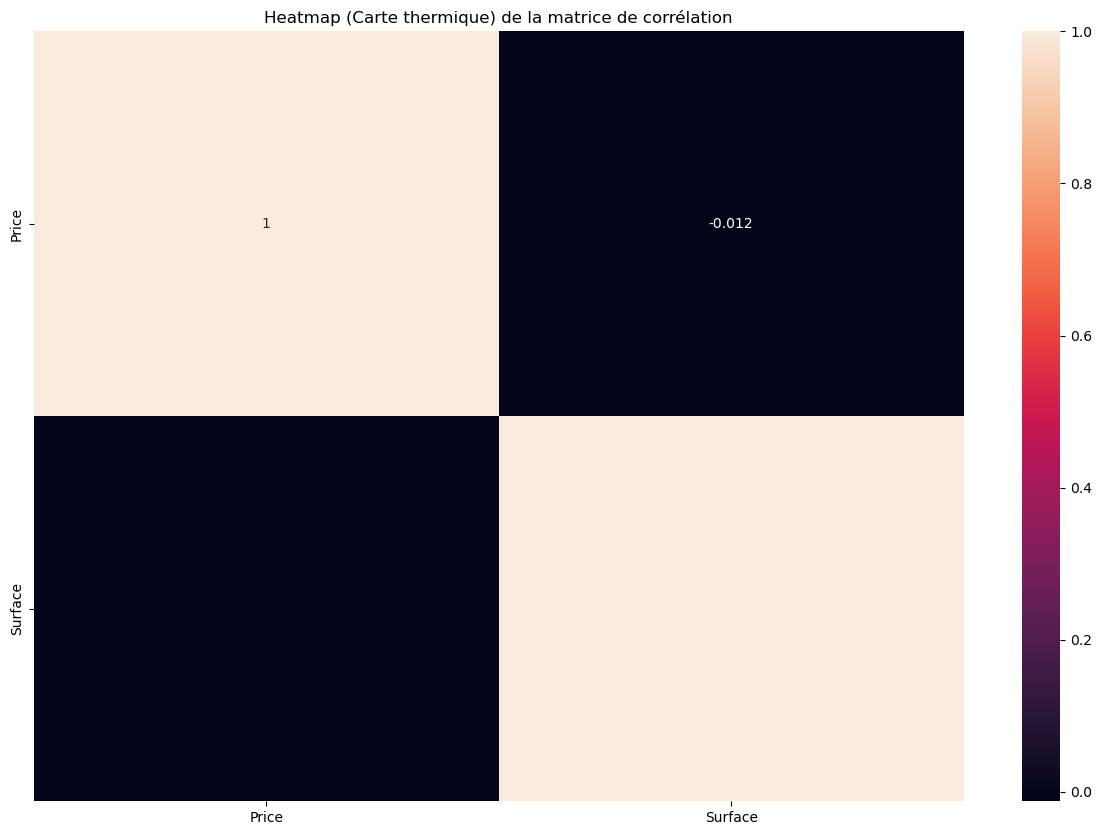

In [258]:
    # Création d'une nouvelle figure pour chaque variable
    plt.figure(figsize=(15, 10))
    sns.heatmap(correlation_matrix, annot=True)
    plt.title('Heatmap (Carte thermique) de la matrice de corrélation')
    plt.show()

**Interpretation :** Dans ce diagramme de dispersion, vous verriez probablement que les points ne forment aucun motif linéaire clair, confirmant visuellement la très faible corrélation entre les deux variables

<br>

#### Analyse Univarié des variables quantitatives

C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 640x480 with 0 Axes>

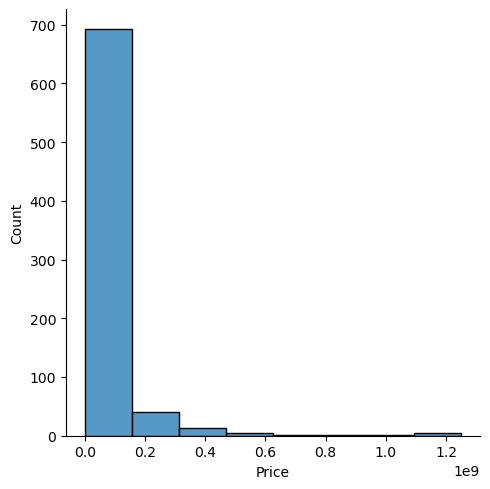

<Figure size 640x480 with 0 Axes>

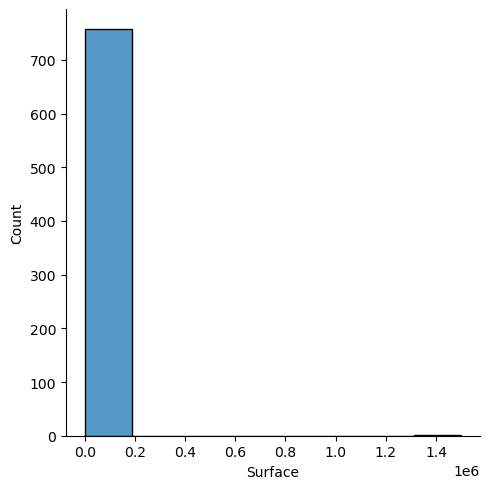

In [253]:
    for var in data_quantitatives:
        # Création d'une nouvelle figure pour chaque variable
        plt.figure()
        # Création d'un histogramme de la variable avec 8 intervalles
        sns.displot(data_quantitatives[var], bins = 8)

Chaque histogramme montre comment les valeurs de chaque variable sont réparties, avec 8 intervalles pour chaque histogramme. Les histogrammes nous aident à visualiser la distribution des données quantitatives, à identifier les tendances et à détecter les anomalies ou les valeurs aberrantes.

<br>

#### Visualisation des valeurs abérants des données quantitatives

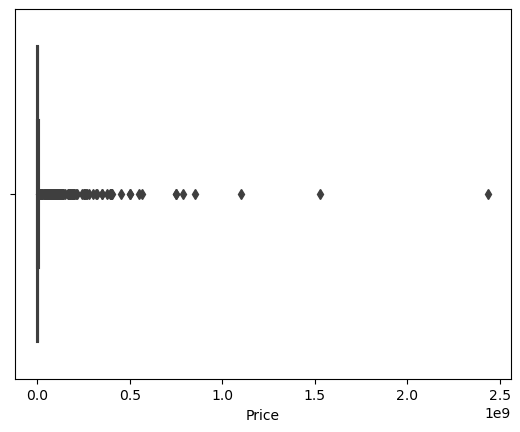

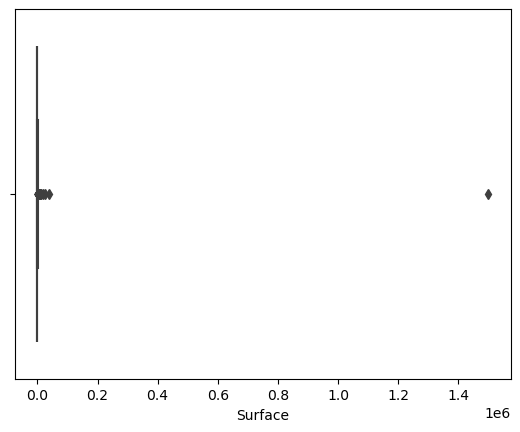

In [114]:
for var in data_quantitatives :
    plt.figure()
    sns.boxplot(x= var, data=data_quantitatives)


#### Interprétation des boxplots :
- La ligne centrale dans chaque boîte représente la médiane des données.
- Les bords de la boîte représentent le premier (Q1) et le troisième quartile (Q3), donc l'interquartile.
- Les "moustaches" (lignes) s'étendent pour montrer l'étendue des données, en excluant les valeurs aberrantes.
- Les points en dehors des moustaches sont considérés comme des valeurs aberrantes potentielles.

Ces visualisations nous aident à comprendre la distribution des données, les asymétries, et à identifier les valeurs aberrantes.

<br>

#### Analyse Univarié des variables qualitatives

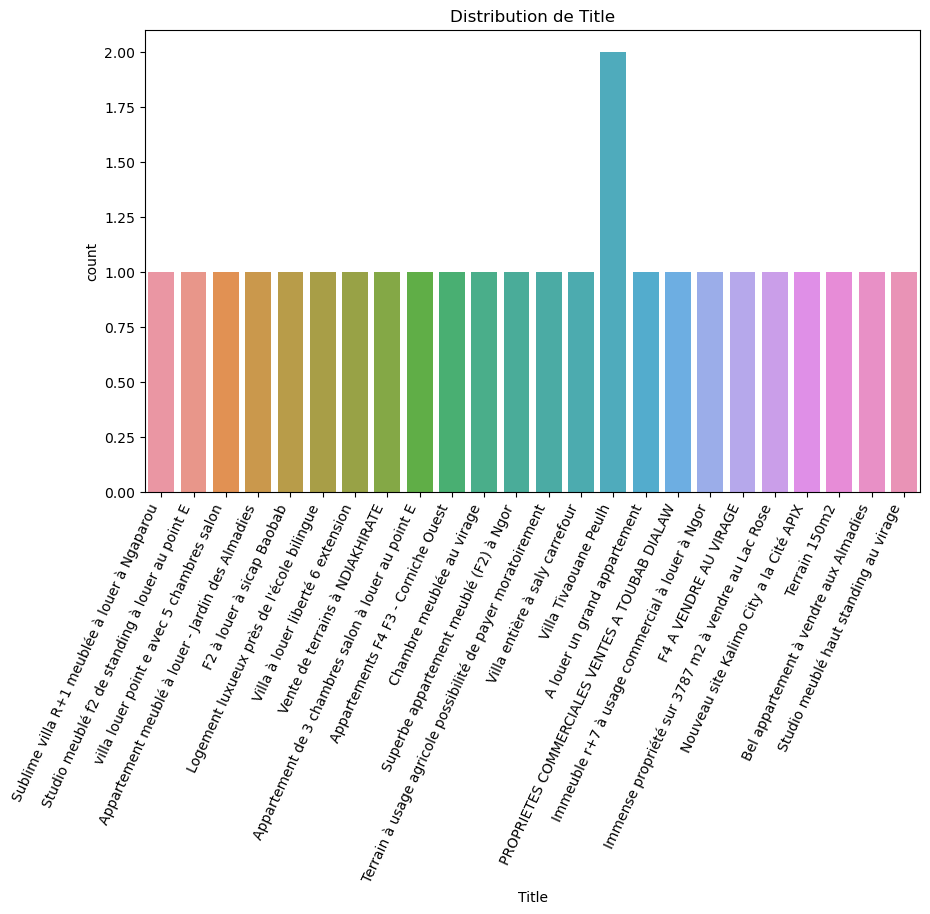

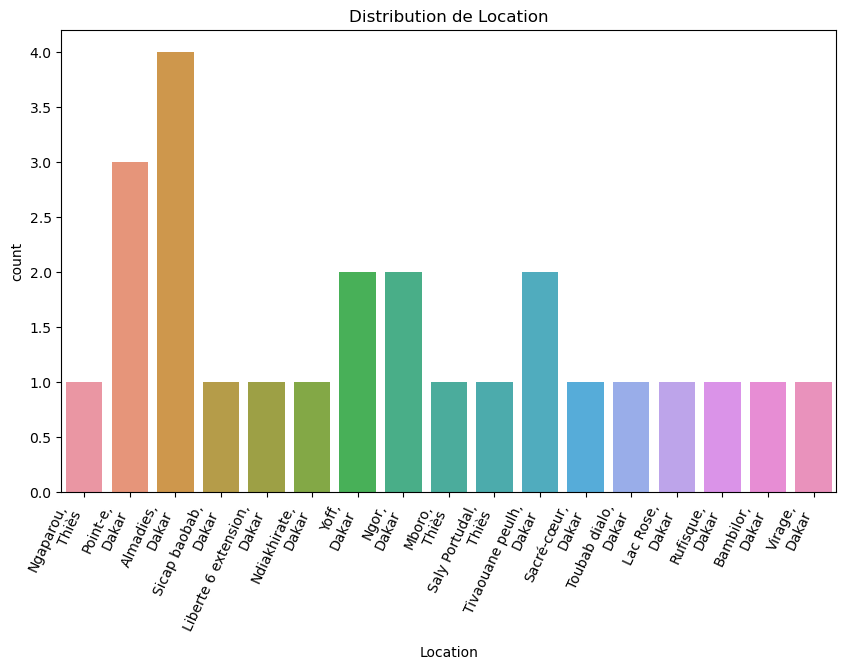

In [266]:
# Sélection d'un échantillon aléatoire de 25 lignes pour la visualisation
data_qualitatives_subset = data_qualitatives.sample(25, random_state=42)

# Création des countplots pour chaque variable qualitative
for var in data_qualitatives_subset:
    # Crée une nouvelle figure
    plt.figure(figsize=(10, 6))
    # Crée un countplot pour la variable actuelle
    sns.countplot(x=data_qualitatives_subset[var])
    # Ajoute un titre pour chaque countplot
    plt.title(f'Distribution de {var}')
    # Ajoute une étiquette pour l'axe x
    plt.xlabel(var)  
    # Fait pivoter les étiquettes de l'axe x pour une meilleure lisibilité
    plt.xticks(rotation=65, ha='right')

# Affichage des graphiques
plt.show()

In [160]:
# Supposons que 'Titre' est la colonne qui contient les titres des annonces
titre_le_plus_frequent = data_qualitatives['Title'].mode()[0]

print(f"Le titre le plus fréquent est : {titre_le_plus_frequent}")

Le titre le plus fréquent est : Almadies King fath palace Très Belle villa R+1 à louer


##### Inerprétation :
    - D'abord avec data_qualitatives.sample(25, random_state=42) : on Sélectionne un échantillon aléatoire de 25 lignes à partir du DataFrame data_qualitatives. random_state=42, fixe la graine du générateur aléatoire pour obtenir des résultats reproductibles. nous obtiendrons le même échantillon chaque fois que nous exécuterons le code avec ce random_state.
    
    - Création des countplots pour chaque variable qualitative : En exécutant ce code, nous obtenons des countplots pour chaque colonne des variables qualitatives (Titles et Location) de l'échantillon aléatoire de 25 lignes sélectionnées de notre DataFrame data_qualitatives. Chaque graphique nous montre la distribution des valeurs pour une variable spécifique, ce qui vous permet de visualiser les fréquences des différentes catégories dans votre échantillon.
    
Dans notre échantillon on constate que le Bien immobilier "Terrain à usage agricole possibilité de payer moratoirement" est le plus fréquent, cela suggère que l'achat errain à usage agricole à Dakar est très courante dans notre échantillon de données, ce qui peut indiquer une forte demande ou une offre abondante dans cette catégorie.

#### Analyse Bivarié

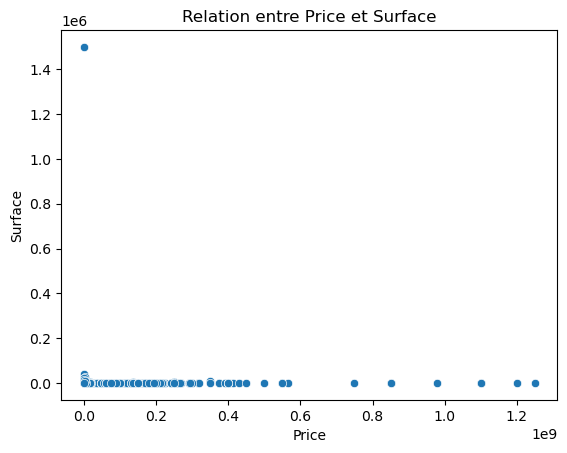

In [268]:
x='Price'
y='Surface'

#  création d'un scatter plot des variables "Surface" et "Price".
sns.scatterplot(x='Price', y='Surface', data=data_quantitatives)
# ajout d'un titre au graphique.
plt.title(f'Relation entre {x} et {y}')
# ajout des étiquettes aux axes x et y respectivement.
plt.xlabel(x)
plt.ylabel(y)
plt.show()

#### Interprétation : 
    - D'abord on crée un scatter plot (nuage de points) en utilisant les colonnes "Price" et "Surface" du DataFrame data. Chaque point sur le graphique représente une observation de votre ensemble de données, avec la valeur "Price" sur l'axe des x et la valeur "Surface" sur l'axe des y.
    
    - Observez la distribution des points. Les points forment une tendance un peu ascendante, cela peut indiquer une relation positive entre le prix et la surface, ce qui signifie que les biens immobiliers plus grands tendent à avoir un prix plus élevé.

    - Les zones où les points sont plus concentrés indiquent des plages de valeurs communes pour les variables "Price" et "Surface".

    - Le point qui est loin de la majorité des données, indique des anomalies ou des valeurs aberrantes dans nos données.

Ce graphique est un outil puissant pour explorer et visualiser la relation entre les deux variables quantitatives dans nos données immobilières.

# Conclusion

## Résumé des objectifs et des résultats
Ce projet de web scraping avait pour objectif de collecter et d'analyser des données sur les annonces immobilières publiées sur le site Expat Dakar. Grâce à l'utilisation d'outils et de technologies appropriés tels que Requests, BeautifulSoup, Pandas, et Matplotlib, nous avons pu extraire et structurer une quantité significative de données pertinentes. L'analyse des données a révélé des tendances intéressantes concernant le marché immobilier à Dakar, notamment en termes de types de biens, de prix, et de localisation géographique.

## Limitations du projet
Malgré les résultats prometteurs, ce projet présente certaines limitations. La collecte de données a été limitée à un nombre défini de pages du site, ce qui pourrait ne pas représenter l'intégralité du marché immobilier. De plus, les annonces peuvent varier en qualité et en complétude des informations fournies, ce qui peut influencer l'exactitude des analyses. Enfin, les données étant statiques, elles ne reflètent qu'un instantané du marché immobilier au moment du scraping.

## Perspectives et recommandations
Pour les futures recherches, il serait bénéfique d'étendre la collecte de données sur une période plus longue pour capturer les variations saisonnières et les tendances à long terme du marché immobilier. L'utilisation de techniques de machine learning pourrait également être explorée pour prédire les tendances du marché basées sur les données historiques. De plus, l'intégration de sources de données supplémentaires, telles que des données économiques ou démographiques, pourrait enrichir l'analyse et fournir des insights encore plus précieux.

En conclusion, ce projet a démontré l'utilité du web scraping pour obtenir des données pertinentes et actuelles sur le marché immobilier à Dakar. Les insights obtenus peuvent aider les investisseurs, les acheteurs potentiels et les professionnels du secteur à prendre des décisions éclairées. Cependant, une analyse continue et une collecte de données plus étendue sont nécessaires pour maintenir à jour notre compréhension du marché immobilier.